In [51]:
%load_ext autoreload
%autoreload

import pandas as pd; pd.set_option('display.max_columns', 30); pd.set_option('display.max_rows', 100)
import numpy as np
from cmlreaders import CMLReader, get_data_index
import ptsa
import sys
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sb
from pylab import *

from copy import copy
plt.rcParams['pdf.fonttype'] = 42; plt.rcParams['ps.fonttype'] = 42 # fix fonts for Illustrator
sys.path.append('/home1/john/SWRrefactored/code/SWR_modules/')
from SWRmodule import *
from general import * #superVstack,findInd,findAinB
from power_functions import z_score, process_power, load_z_scored_power

base = '/home1/john/SWRrefactored'
sys.path.append(f'{base}/code/')

from load_data_numpy import load_data_np
from SWRmodule import triangleSmooth
# from comodulogram import remove_session_string, get_filtered_signal
# from fooof import FOOOF

import statsmodels.formula.api as smf
from scipy.signal import decimate, resample, hilbert, welch, spectrogram
from mne.time_frequency import tfr_array_morlet

# # Import the time & event model objects and Bands object to manage oscillation band definitions
# from specparam import SpectralTimeModel, SpectralTimeEventModel, Bands
# # Import helper utilities for simulating and plotting spectrograms
# from specparam.sim import sim_spectrogram
# from specparam.plts.spectra import plot_spectrogram

# np.logspace(np.log10(80),np.log10(178),10)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
# for now the plotting code only works with one region at a time
region_name = ['ACC_OF'] # ['ENT'] # ['AMY'] ['HPC'] ['ACC_OF']
subregion = ['ca1'] #['ca1'] # can use [''] to select ALL subregions
task = 'catFR1' # 'catFR1'
savePath = f'{base}/figures/'

# 1 for encoding, 0 for recall
encoding_mode_arr = [0] #,1] #[0,1] "
freq_range_str_arr = [[33.5,75],[80,120]] #,[7,9],[33.5,75],[80,120]] #[[33.5,75],[80,120]] #,[2,4],[7,9]] # [80,178]
# these were selecetd to avoid 60 and 120 Hz using np.logspace(np.log10(30),np.log10(75),10)

fs = 500 # sampling rate for raw data and ripples from createEventsForDF.py

In [56]:
# load data from dd_trials
# If you've previously loaded with load_anew but think there are new sessions, need to rerun to get updated .npz

load_anew = 0 # load power_z anew without saving or loading from previous runs

for encoding_mode in encoding_mode_arr:

    dd_trials = load_data_np(encoding_mode,task,
        region_name=region_name, train_only=False, subregion=subregion)

    region_str = region_name[0]
    subregion_str = subregion[0]
    
    clust = dd_trials['clust_int']
    
    start_cutoff = 0 # in samples
    if encoding_mode == 1: # raw is from -1.7 to 3.3 s from word_on
        saveName = 'encoding_'
        recall_str = ''
        correct = dd_trials['correct']
        incorrect_idxs = np.argwhere(correct==0).squeeze()
        end_cutoff = 2500 # just take the whole range of data to better estimate Morlet     
 
    elif encoding_mode == 0: # raw is from -3 to 3 s from recall
        saveName = 'recall_'
        recall_str = '_recall'
        end_cutoff = 6000 # 3000 # just take the whole range of data to better estimate Morlet 
        # 3000 is with IRI = 2000 (buffer 500 on either side)
        # 6000 is with IRI = 5000 (buffer 500 on either side)

    sr_factor = 1000/fs
    
    # Generate power_z
    
    print("Generating figures for run_mode: ", encoding_mode)
    power_z = None  # Initialize power_z as None
    if load_anew == 1: # if encoding need to save in pieces
        # for recall can load them all together in power_z
        power_z = load_z_scored_power(dd_trials, freq_range_str_arr, encoding_mode,fs,start_cutoff, end_cutoff)
    else:
        for freq in freq_range_str_arr:
            saved_power_z_fn = f'/scratch/john/SWRrefactored/temp_dat/power_z_{task}_{saveName}{region_name[0]}_{subregion[0]}_freq{freq[0]}.npz'
            
            if power_z is None:
                if os.path.exists(saved_power_z_fn):
                    # Loading the file without creating a full copy in memory
                    power_z = np.load(saved_power_z_fn, mmap_mode='r')['power_z']
                else: # if hasn't been made yet: create power_z anew
                    power_z = load_z_scored_power(dd_trials, [freq], encoding_mode, fs, start_cutoff, end_cutoff)
                    power_z = np.expand_dims(power_z, axis=0)  # Add the first dimension
                    np.savez_compressed(saved_power_z_fn, power_z=power_z)
            else:
                if os.path.exists(saved_power_z_fn):
                    # Load the next frequency data directly into a new slice of power_z
                    next_slice = np.load(saved_power_z_fn, mmap_mode='r')['power_z']
                else:
                    next_slice = load_z_scored_power(dd_trials, [freq], encoding_mode, fs, start_cutoff, end_cutoff)
                    next_slice = np.expand_dims(next_slice, axis=0)  # Add the first dimension
                    np.savez_compressed(saved_power_z_fn, power_z=next_slice)
                # Append next_slice along the first dimension by expanding power_z
                import gc # import garbage collection
                power_z = np.concatenate((power_z, next_slice), axis=0)   
                del next_slice # delete and trigger garbage collection
                gc.collect()
        
    # note that output is 50 Hz (20 ms bins) since started 500 hz and decimated 10x
    if len(subregion[0]) > 0:
        subregion_str = f'_{subregion[0]}'
    else:
        subregion_str = ''           

a=1;            

Loading data
LOADING DATA FROM: ACC_OF FOR EXPERIMENT catFR1
Number of trials after load: 4942
Final number of trials in dict: 29952
order: C
Generating figures for run_mode:  0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   58.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   58.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   57.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   57.6s finished


In [58]:
# info
dd_trials.keys()
np.shape(dd_trials['ripple'])
np.shape(dd_trials['raw'])

np.shape(power_z)
freq_range_str_arr

unique_subs = np.unique(dd_trials['subj'])
unique_subs

dict_keys(['ripple', 'list_num', 'subj', 'sess', 'elec_names', 'elec_labels', 'clust', 'raw', 'elec_by_elec_correlation', 'serial_pos', 'recall_pos', 'trial_by_trial_correlation', 'elec_ripple_rate_array', 'clust_int'])

(29952, 5000)

(29952, 6000)

(2, 29952, 600)

[[33.5, 75], [80, 120]]

array(['R1041M', 'R1045E', 'R1061T', 'R1074M', 'R1105E', 'R1106M',
       'R1131M', 'R1138T', 'R1157C', 'R1158T', 'R1171M', 'R1174T',
       'R1180C', 'R1192C', 'R1204T', 'R1217T', 'R1231M', 'R1239E',
       'R1243T', 'R1264P', 'R1275D', 'R1279P', 'R1303E', 'R1315T',
       'R1320D', 'R1330D', 'R1337E', 'R1342M', 'R1343J', 'R1347D',
       'R1348J', 'R1354E', 'R1361C', 'R1364C', 'R1366J', 'R1367D',
       'R1368T', 'R1370E', 'R1372C', 'R1376D', 'R1378T', 'R1379E',
       'R1380D', 'R1382T', 'R1383J', 'R1384J', 'R1385E', 'R1391T',
       'R1394E', 'R1395M', 'R1398J', 'R1400N', 'R1401J', 'R1403N',
       'R1404E', 'R1405E', 'R1406M', 'R1408N', 'R1409D', 'R1412M',
       'R1413D', 'R1414E', 'R1421M', 'R1422T', 'R1423E', 'R1426N',
       'R1427T', 'R1436J', 'R1441T', 'R1443D', 'R1444D', 'R1447M',
       'R1450D', 'R1454M', 'R1457T', 'R1459M', 'R1463E', 'R1465D',
       'R1468J', 'R1469D', 'R1472T', 'R1473J', 'R1476J', 'R1477J',
       'R1484T', 'R1485J', 'R1487T', 'R1489E', 'R1490T', 'R149

In [75]:
gamma_sd_thresh = -12.0
remove_first_recalls = 2 # 1 means remove 1st, 2 means keep ONLY first, other for all
left_only = 2 # 1 for left, 2 for right, other for all

# select a patient?
patient_idx = -1 # -1 means all

if patient_idx >-1: 
    sub_idxs = dd_trials['subj']==unique_subs[patient_idx]
else:
    sub_idxs = np.ones(len(dd_trials['subj']),dtype=bool)

# select left vs. right
if left_only == 1:
    left_index = ['left' in elec for elec in dd_trials['elec_names']]
    sub_idxs = left_index  & sub_idxs
elif left_only == 2:
    right_index = ['right' in elec for elec in dd_trials['elec_names']]
    sub_idxs = right_index  & sub_idxs
    
print(f'Number of trials: {sum(sub_idxs)} from the following subs:')
# np.unique(dd_trials['subj'][sub_idxs])

# if recalls remove the intrusions
if encoding_mode == 0:
    if remove_first_recalls == 1:
        final_sub_idxs = (sub_idxs) & (clust!=0) & (dd_trials['recall_pos']!=1)
    elif remove_first_recalls == 2:
        final_sub_idxs = (sub_idxs) & (clust!=0) & (dd_trials['recall_pos']==1)        
    else:
        final_sub_idxs = (sub_idxs) & (clust!=0)
else:
    final_sub_idxs = sub_idxs
      
# update each variable with indices
sub_ripples = dd_trials['ripple'][final_sub_idxs] # ripples are detected from -0.7 to 2.3 s @ 500 Hz
if power_z.ndim == 2:
    power_z = power_z[np.newaxis, :, :]
sub_Zs = power_z[:,final_sub_idxs,:]
sub_clust_ID = clust[final_sub_idxs]
np.shape(sub_Zs)

z_factor = sr_factor*10 # z_score was decimated 10x
if encoding_mode == 1:
    ripple_start_offset = -700 # ripple_trials go from -0.7 to 2.3 s (no buffers)
    ripple_analysis_start = 300 # time in ms
    ripple_analysis_end = 1300 # time in ms
    
    # average z-score over time for same range as ripples
    gamma_time_range = slice(int((1700+ripple_analysis_start)/z_factor),int((1700+ripple_analysis_end)/z_factor)) # +1700 since goes from -1.7 to 3.3 s   
    
elif encoding_mode == 0:
    ripple_start_offset = -(end_cutoff-1000) #-2000 # ripple matrix 2000 ms on either side of recall
    ripple_analysis_start = -1900 # time in ms
    ripple_analysis_end = -100 # time in ms    

    # average z-score over time for same range as ripples
    gamma_time_range = slice(int((3000+ripple_analysis_start)/z_factor),int((3000+ripple_analysis_end)/z_factor)) # +3000 since goes from -3 to 3 s
# calculate ranges for plots below    
ripple_swarm_start = int((-ripple_start_offset+ripple_analysis_start)/sr_factor)
ripple_swarm_end = int((-ripple_start_offset+ripple_analysis_end)/sr_factor)
ripple_swarm_duration = (ripple_analysis_end-ripple_analysis_start)/1000  # convert to seconds
    
# get idxs for trial selection in plots below
clust_clustered = sub_clust_ID > 1
clust_unclustered = sub_clust_ID < 0
clust_not_recalled = sub_clust_ID == 0

# get start_array for all ripples!
start_array,_ = getStartEndArrays(sub_ripples)
# first bin has artificially high number due to how start_srray works
start_array = start_array[:,1:] 
print(f'start array shape: {np.shape(start_array)}')
    
# check power > thresh in gamma time range
z_low_gamma_trials = np.mean(sub_Zs[0,:,gamma_time_range],1)>=gamma_sd_thresh
if np.shape(sub_Zs)[0]>1:
    z_high_gamma_trials = np.mean(sub_Zs[1,:,gamma_time_range],1)>=gamma_sd_thresh     
    
ripple_trials = np.sum(sub_ripples[:,int((-ripple_start_offset+ripple_analysis_start)/sr_factor):
                                   int((-ripple_start_offset+ripple_analysis_end)/sr_factor)],1)>0
print(f'{sum(ripple_trials)} trials have ripples which is {np.round(100*sum(ripple_trials)/sum(final_sub_idxs),2)}% of total')

# create df for Cohen's D calcs and models below
ripple_data = start_array[:, ripple_swarm_start:ripple_swarm_end].sum(axis=1)

# Create a DataFrame with the data
df = pd.DataFrame({
    'ripple_rate': ripple_data,
    'clust_clustered': (sub_clust_ID > 1).astype(int),
    'clust_unclustered': (sub_clust_ID < 0).astype(int),
    'clust_not_recalled': (sub_clust_ID == 0).astype(int),
    'session': dd_trials['sess'][final_sub_idxs],
    'subject': dd_trials['subj'][final_sub_idxs],
    'elec_labels': dd_trials['elec_labels'][final_sub_idxs],
    'low_gamma': z_low_gamma_trials,
})

Number of trials: 13004 from the following subs:


(2, 7648, 600)

start array shape: (7648, 4999)
1287 trials have ripples which is 16.83% of total


## some checks:

In [76]:
print(f"{len(np.unique(dd_trials['elec_labels'][sub_idxs]))} elecs")
print(f"from {len(np.unique(dd_trials['sess'][sub_idxs]))} sessions")
print(f"from {len(np.unique(dd_trials['subj'][sub_idxs]))} patients")

if region_name == ['ENT']:
    ENT_sess = np.unique(dd_trials['sess'][sub_idxs])
    ENT_sub = np.unique(dd_trials['subj'][sub_idxs])
elif region_name == ['HPC']:
    HPC_sess = np.unique(dd_trials['sess'][sub_idxs])
    HPC_sub = np.unique(dd_trials['subj'][sub_idxs])
elif region_name == ['AMY']:
    AMY_sess = np.unique(dd_trials['sess'][sub_idxs])
    AMY_sub = np.unique(dd_trials['subj'][sub_idxs])
    
save_sub_sess_info = 0

if save_sub_sess_info == 1:
    import pickle
    with open('../misc/region_data.pkl', 'wb') as f:
        pickle.dump({
            'ENT_sess': ENT_sess,
            'ENT_sub': ENT_sub,
            'HPC_sess': HPC_sess,
            'HPC_sub': HPC_sub,
            'AMY_sess': AMY_sess,
            'AMY_sub': AMY_sub
        }, f)   
        
dd_trials['elec_labels']
len(dd_trials['elec_labels'][final_sub_idxs])
len(dd_trials['subj'][final_sub_idxs])
len(dd_trials['sess'][final_sub_idxs])
np.shape(sub_Zs)
len(sub_clust_ID)        

741 elecs
from 150 sessions
from 68 patients


array(['R1343J-1_LJ1-LJ2', 'R1343J-1_LJ2-LJ3', 'R1343J-1_LJ3-LJ4', ...,
       'R1171M-0_RO4-RO5', 'R1171M-0_RO5-RO6', 'R1171M-0_RO6-RO7'],
      dtype='<U24')

7648

7648

7648

(2, 7648, 600)

7648

# ripples (–) low gamma trials

In [77]:
# which to remove from the first two ranges in freq_range_str_arr
remove_low_freq = 1 # 1 for low gamma/theta; 2 for high gamma/theta

/tmp/ipykernel_141303/2018321735.py:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_bar.set_xticklabels(['Clustered', 'Unclustered', 'Not Recalled'], rotation=0, ha="center")
/home1/john/SWRrefactored/code/SWR_modules/SWRmodule.py:1411: RuntimeWarning: invalid value encountered in divide
  norm_count = count[0]/np.array((num_trials*binsize/1000))


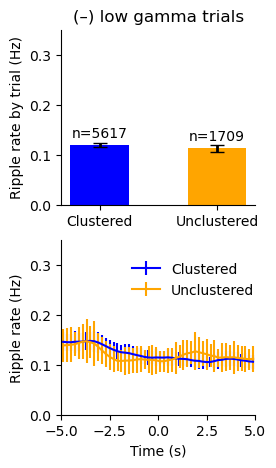

Rate ratio: 1.0569781454111744
Cohen's D by subject: 0.05622412382618756


In [78]:
import matplotlib.gridspec as gridspec

# Function parameters
bin_size = 200  # in ms
smoothing_triangle = 8  # triangular smoothing window width

bar_ylimits = (0, 0.35)

if remove_low_freq == 1:
    trial_select = z_low_gamma_trials
    freq_range = freq_range_str_arr[0]
elif remove_low_freq == 2:
    trial_select = z_high_gamma_trials
    freq_range = freq_range_str_arr[1]
else:
    print('Invalid remove_low_freq selection')
    error    
if 29 < freq_range[0] < 35:
    freq_label = 'low gamma'
elif 65 < freq_range[0] < 90:
    freq_label = 'high gamma' 
elif 1 < freq_range[0] < 3:
    freq_label = 'theta'
elif 6 < freq_range[0] < 8:
    freq_label = 'theta'

# Calculate ripple means and standard errors for each condition
mean_ripple_clustered = np.sum(start_array[trial_select & clust_clustered, ripple_swarm_start:ripple_swarm_end], axis=1) / ripple_swarm_duration
mean_ripple_unclustered = np.sum(start_array[trial_select & clust_unclustered, ripple_swarm_start:ripple_swarm_end], axis=1) / ripple_swarm_duration
mean_ripple_not_recalled = np.sum(start_array[trial_select & clust_not_recalled, ripple_swarm_start:ripple_swarm_end], axis=1) / ripple_swarm_duration

if encoding_mode == 1:
    means = [np.mean(mean_ripple_clustered), np.mean(mean_ripple_unclustered), np.mean(mean_ripple_not_recalled)]
    ses = [np.std(mean_ripple_clustered) / np.sqrt(len(mean_ripple_clustered)),
           np.std(mean_ripple_unclustered) / np.sqrt(len(mean_ripple_unclustered)),
           np.std(mean_ripple_not_recalled) / np.sqrt(len(mean_ripple_not_recalled))]
    fig = plt.figure(figsize=(3.2, 5))
elif encoding_mode == 0:
    means = [np.mean(mean_ripple_clustered), np.mean(mean_ripple_unclustered)]
    ses = [np.std(mean_ripple_clustered) / np.sqrt(len(mean_ripple_clustered)),
           np.std(mean_ripple_unclustered) / np.sqrt(len(mean_ripple_unclustered))]    
    fig = plt.figure(figsize=(2.5, 5))

# Define the palette for colors
palette = {
    'Clustered': 'blue',
    'Unclustered': 'orange',
    'Not Recalled': 'green'
}

# Set up the figure with GridSpec
gs = gridspec.GridSpec(2, 3, height_ratios=[2, 2], width_ratios=[3, 3, 3])

# Create the bar plot with error bars (span all columns)
ax_bar = fig.add_subplot(gs[0, :])
if encoding_mode == 1:
    xlabels = ['Clustered', 'Unclustered', 'Not Recalled']
    xcolors = [palette['Clustered'], palette['Unclustered'], palette['Not Recalled']]
elif encoding_mode == 0:
    xlabels = ['Clustered', 'Unclustered']
    xcolors = [palette['Clustered'], palette['Unclustered']]
bars = ax_bar.bar(x=xlabels, 
                  height=means, 
                  color=xcolors, 
                  yerr=ses, 
                  width=0.5,  # Adjust width to make bars tighter
                  capsize=5, 
                  error_kw=dict(ecolor='black', elinewidth=2))

ax_bar.set_ylabel('Ripple rate by trial (Hz)')
ax_bar.set_xlabel('')
ax_bar.set_ylim(bar_ylimits)
ax_bar.set_xticklabels(['Clustered', 'Unclustered', 'Not Recalled'], rotation=0, ha="center")
ax_bar.spines['right'].set_visible(False)
ax_bar.spines['top'].set_visible(False)
ax_bar.set_title(f'(–) {freq_label} trials')

# Add the number of trials above each bar
n_trials = [np.sum(trial_select & clust_clustered), 
            np.sum(trial_select & clust_unclustered), 
            np.sum(trial_select & clust_not_recalled)]
for bar, n in zip(bars, n_trials):
    ax_bar.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'n={n}', ha='center', va='bottom')

# Calculate PSTH for each group
ripple_PSTH_clustered, bin_centers = fullPSTH(start_array[trial_select & clust_clustered], bin_size, smoothing_triangle, fs, ripple_start_offset)
ripple_PSTH_unclustered, _ = fullPSTH(start_array[trial_select & clust_unclustered], bin_size, smoothing_triangle, fs, ripple_start_offset)
ripple_PSTH_not_recalled, _ = fullPSTH(start_array[trial_select & clust_not_recalled], bin_size, smoothing_triangle, fs, ripple_start_offset)

# Bin the start_array to match the PSTH
n_bins = len(bin_centers)
binned_start_array_clustered = np.array_split(start_array[trial_select & clust_clustered], n_bins, axis=1)

# Calculate the mean and SE for each bin
se_clustered = [np.std(bin_data*fs, axis=1) / np.sqrt(bin_data.shape[0]) for bin_data in binned_start_array_clustered]
se_clustered = np.mean(se_clustered, axis=1)

binned_start_array_unclustered = np.array_split(start_array[trial_select & clust_unclustered], n_bins, axis=1)
se_unclustered = [np.std(bin_data*fs, axis=1) / np.sqrt(bin_data.shape[0]) for bin_data in binned_start_array_unclustered]
se_unclustered = np.mean(se_unclustered, axis=1)

if encoding_mode == 1:
    binned_start_array_not_recalled = np.array_split(start_array[trial_select & clust_not_recalled], n_bins, axis=1)
    se_not_recalled = [np.std(bin_data*fs, axis=1) / np.sqrt(bin_data.shape[0]) for bin_data in binned_start_array_not_recalled]
    se_not_recalled = np.mean(se_not_recalled, axis=1)

# Plot the PSTH for each group with error bars
ax_psth = fig.add_subplot(gs[1, :])
ax_psth.errorbar(bin_centers / 1000-0.01, ripple_PSTH_clustered, yerr=se_clustered, label='Clustered', color=palette['Clustered'], capsize=0)
ax_psth.errorbar(bin_centers / 1000, ripple_PSTH_unclustered, yerr=se_unclustered, label='Unclustered', color=palette['Unclustered'], capsize=0)
if encoding_mode == 1:
    ax_psth.errorbar(bin_centers / 1000+0.01, ripple_PSTH_not_recalled, yerr=se_not_recalled, label='Not Recalled', color=palette['Not Recalled'], capsize=0)
    ax_psth.axvline(x=0.0, color='black', linestyle='--')
    ax_psth.axvline(x=1.6, color='black', linestyle='--')
    ax_psth.set_xlim(-0.28, 2.08)
elif encoding_mode == 0:
    ax_psth.set_xlim(-(end_cutoff-1000)/1000, (end_cutoff-1000)/1000)
ax_psth.set_xlabel('Time (s)')
ax_psth.set_ylim(0, bar_ylimits[1])
ax_psth.set_ylabel('Ripple rate (Hz)')
ax_psth.spines['right'].set_visible(False)
ax_psth.spines['top'].set_visible(False)

# Add legend to the bottom plot
ax_psth.legend(bbox_to_anchor=(0.3,0.6), frameon=False)

# plt.tight_layout()
plt.show()
print(f'Rate ratio: {(np.mean(mean_ripple_clustered)/np.mean(mean_ripple_unclustered))}')
average_ripple_rate_by_subject = df.groupby('subject')['ripple_rate'].mean().values
average_ripple_rate_by_subject = average_ripple_rate_by_subject[average_ripple_rate_by_subject>=0.1] # to properly estimate std
print(f"Cohen's D by subject: {(np.mean(mean_ripple_clustered)-np.mean(mean_ripple_unclustered))/np.std(average_ripple_rate_by_subject)}")
# mean_ripple_clustered[mean_ripple_clustered>1]=1
# mean_ripple_unclustered[mean_ripple_unclustered>1]=1
# mean_ripple_not_recalled[mean_ripple_not_recalled>1]=1
# print(f'Odds ratio of binarized: {(sum(mean_ripple_clustered)*sum(mean_ripple_unclustered==0))/(sum(mean_ripple_unclustered)*sum(mean_ripple_clustered==0))}')

a=1;

# ripples for (+) low gamma trials

/home1/john/anaconda3/envs/workshopJ/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: FixedFormatter should only be used together with FixedLocator
/home1/john/SWRrefactored/code/SWR_modules/SWRmodule.py:1410: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  norm_count = count/np.array((num_trials*binsize/1000))
/home1/john/SWRrefactored/code/SWR_modules/SWRmodule.py:1410: RuntimeWarning: invalid value encountered in true_divide
  norm_count = count/np.array((num_trials*binsize/1000))
/home1/john/SWRrefactored/code/SWR_modules/SWRmodule.py:1410: RuntimeWarning: divide by zero encountered in true_divide
  norm_count = count/np.array((num_trials*binsize/1000))


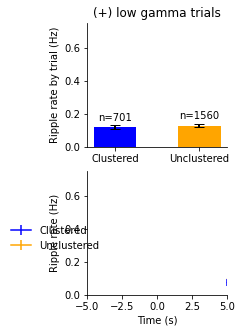

Rate ratio: 0.9137784011667289
Cohen's D by subject: -0.08530313064714783


In [36]:
# Function parameters
bin_size = 100  # in ms
smoothing_triangle = 5  # triangular smoothing window width

bar_ylimits = (0, 0.75)

if remove_low_freq == 1:
    trial_select = z_low_gamma_trials
elif remove_low_freq == 2:
    trial_select = z_high_gamma_trials
else:
    print('Invalid remove_low_freq selection')
    error

# Calculate ripple means and standard errors for each condition
mean_ripple_clustered = np.sum(start_array[trial_select & clust_clustered, ripple_swarm_start:ripple_swarm_end], axis=1) / ripple_swarm_duration
mean_ripple_unclustered = np.sum(start_array[trial_select & clust_unclustered, ripple_swarm_start:ripple_swarm_end], axis=1) / ripple_swarm_duration
mean_ripple_not_recalled = np.sum(start_array[trial_select & clust_not_recalled, ripple_swarm_start:ripple_swarm_end], axis=1) / ripple_swarm_duration

if encoding_mode == 1:
    means = [np.mean(mean_ripple_clustered), np.mean(mean_ripple_unclustered), np.mean(mean_ripple_not_recalled)]
    ses = [np.std(mean_ripple_clustered) / np.sqrt(len(mean_ripple_clustered)),
           np.std(mean_ripple_unclustered) / np.sqrt(len(mean_ripple_unclustered)),
           np.std(mean_ripple_not_recalled) / np.sqrt(len(mean_ripple_not_recalled))]
    fig = plt.figure(figsize=(3.2, 5))
elif encoding_mode == 0:
    means = [np.mean(mean_ripple_clustered), np.mean(mean_ripple_unclustered)]
    ses = [np.std(mean_ripple_clustered) / np.sqrt(len(mean_ripple_clustered)),
           np.std(mean_ripple_unclustered) / np.sqrt(len(mean_ripple_unclustered))]    
    fig = plt.figure(figsize=(2.5, 5))

# Define the palette for colors
palette = {
    'Clustered': 'blue',
    'Unclustered': 'orange',
    'Not Recalled': 'green'
}

# Set up the figure with GridSpec
gs = gridspec.GridSpec(2, 3, height_ratios=[2, 2], width_ratios=[3, 3, 3])

# Create the bar plot with error bars (span all columns)
ax_bar = fig.add_subplot(gs[0, :])
if encoding_mode == 1:
    xlabels = ['Clustered', 'Unclustered', 'Not Recalled']
    xcolors = [palette['Clustered'], palette['Unclustered'], palette['Not Recalled']]
elif encoding_mode == 0:
    xlabels = ['Clustered', 'Unclustered']
    xcolors = [palette['Clustered'], palette['Unclustered']]
bars = ax_bar.bar(x=xlabels, 
                  height=means, 
                  color=xcolors, 
                  yerr=ses, 
                  width=0.5,  # Adjust width to make bars tighter
                  capsize=5, 
                  error_kw=dict(ecolor='black', elinewidth=2))

ax_bar.set_ylabel('Ripple rate by trial (Hz)')
ax_bar.set_xlabel('')
ax_bar.set_ylim(bar_ylimits)
ax_bar.set_xticklabels(xlabels, rotation=0, ha="center")
ax_bar.spines['right'].set_visible(False)
ax_bar.spines['top'].set_visible(False)
ax_bar.set_title(f'(+) {freq_label} trials')

# Add the number of trials above each bar
n_trials = [np.sum(trial_select & clust_clustered), 
            np.sum(trial_select & clust_unclustered), 
            np.sum(trial_select & clust_not_recalled)]
for bar, n in zip(bars, n_trials):
    ax_bar.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.03, f'n={n}', ha='center', va='bottom')

# Calculate PSTH for each group
ripple_PSTH_clustered, bin_centers = fullPSTH(start_array[trial_select & clust_clustered], bin_size, smoothing_triangle, fs, ripple_start_offset)
ripple_PSTH_unclustered, _ = fullPSTH(start_array[trial_select & clust_unclustered], bin_size, smoothing_triangle, fs, ripple_start_offset)
ripple_PSTH_not_recalled, _ = fullPSTH(start_array[trial_select & clust_not_recalled], bin_size, smoothing_triangle, fs, ripple_start_offset)

# Bin the start_array to match the PSTH
n_bins = len(bin_centers)
binned_start_array_clustered = np.array_split(start_array[trial_select & clust_clustered], n_bins, axis=1)

# Calculate the mean and SE for each bin
se_clustered = [np.std(bin_data*fs, axis=1) / np.sqrt(bin_data.shape[0]) for bin_data in binned_start_array_clustered]
se_clustered = np.mean(se_clustered, axis=1)

binned_start_array_unclustered = np.array_split(start_array[trial_select & clust_unclustered], n_bins, axis=1)
se_unclustered = [np.std(bin_data*fs, axis=1) / np.sqrt(bin_data.shape[0]) for bin_data in binned_start_array_unclustered]
se_unclustered = np.mean(se_unclustered, axis=1)

if encoding_mode == 1:
    binned_start_array_not_recalled = np.array_split(start_array[trial_select & clust_not_recalled], n_bins, axis=1)
    se_not_recalled = [np.std(bin_data*fs, axis=1) / np.sqrt(bin_data.shape[0]) for bin_data in binned_start_array_not_recalled]
    se_not_recalled = np.mean(se_not_recalled, axis=1)

# Plot the PSTH for each group with error bars
ax_psth = fig.add_subplot(gs[1, :])
ax_psth.errorbar(bin_centers / 1000-0.01, ripple_PSTH_clustered, yerr=se_clustered, label='Clustered', color=palette['Clustered'], capsize=0)
ax_psth.errorbar(bin_centers / 1000, ripple_PSTH_unclustered, yerr=se_unclustered, label='Unclustered', color=palette['Unclustered'], capsize=0)
if encoding_mode == 1:
    ax_psth.errorbar(bin_centers / 1000+0.01, ripple_PSTH_not_recalled, yerr=se_not_recalled, label='Not Recalled', color=palette['Not Recalled'], capsize=0)
    ax_psth.axvline(x=0.0, color='black', linestyle='--')
    ax_psth.axvline(x=1.6, color='black', linestyle='--')
    ax_psth.set_xlim(-0.28, 2.08)
elif encoding_mode == 0:
    ax_psth.set_xlim(-(end_cutoff-1000)/1000, (end_cutoff-1000)/1000)
ax_psth.set_xlabel('Time (s)')
ax_psth.set_ylim(0, bar_ylimits[1])
ax_psth.set_ylabel('Ripple rate (Hz)')
ax_psth.spines['right'].set_visible(False)
ax_psth.spines['top'].set_visible(False)

# Add legend to the bottom plot
if freq_label == 'theta':
    ax_psth.legend(bbox_to_anchor=(0.15,0.63), frameon=False) # (0.46,0.42),
else:
    ax_psth.legend(frameon=False,bbox_to_anchor=(0.15,0.63)) #(0.77,0.5)) #(0.33,0.72) #(0.15,0.63)

# Adjust layout
# plt.tight_layout()
plt.show()
print(f'Rate ratio: {(np.mean(mean_ripple_clustered)/np.mean(mean_ripple_unclustered))}')
average_ripple_rate_by_subject = df.groupby('subject')['ripple_rate'].mean().values
average_ripple_rate_by_subject = average_ripple_rate_by_subject[average_ripple_rate_by_subject>=0.1] # to properly estimate std
print(f"Cohen's D by subject: {(np.mean(mean_ripple_clustered)-np.mean(mean_ripple_unclustered))/np.std(average_ripple_rate_by_subject)}")
# mean_ripple_clustered[mean_ripple_clustered>1]=1
# mean_ripple_unclustered[mean_ripple_unclustered>1]=1
# mean_ripple_not_recalled[mean_ripple_not_recalled>1]=1
# print(f'Odds ratio of binarized: {(sum(mean_ripple_clustered)*sum(mean_ripple_unclustered==0))/(sum(mean_ripple_unclustered)*sum(mean_ripple_clustered==0))}')

a=1;

In [122]:
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm

if remove_low_freq == 2:
    df['high_gamma'] = z_high_gamma_trials

# Define the model formula
# 'ripple_rate ~ clust_clustered + clust_unclustered + clust_not_recalled' specifies the fixed effects
# '(1 | subject/session)' specifies the random effects, with session nested within subject
if encoding_mode == 1:
    formula = "ripple_rate ~ clust_clustered + clust_unclustered"
elif encoding_mode == 0:
    formula = "ripple_rate ~ clust_clustered" # since not recalled doesn't exist
model = mixedlm(
    formula=formula,data=df, groups=df["subject"], vc_formula={"session": "0 + session"})

print(model.fit().summary())

           Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: ripple_rate 
No. Observations:   117768  Method:             REML        
No. Groups:         99      Scale:              0.3402      
Min. group size:    84      Log-Likelihood:     -103954.7535
Max. group size:    10800   Converged:          Yes         
Mean group size:    1189.6                                  
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept          0.278    0.011 25.161 0.000  0.256  0.299
clust_clustered    0.017    0.005  3.573 0.000  0.008  0.027
clust_unclustered -0.009    0.005 -1.819 0.069 -0.019  0.001
session Var        0.022    0.004                           



In [123]:
if encoding_mode == 1:
    if remove_low_freq == 1:
        formula = "ripple_rate ~ low_gamma*(clust_clustered + clust_unclustered)"
        formula_main = "ripple_rate ~ low_gamma+(clust_clustered + clust_unclustered)"
    elif remove_low_freq == 2:
        formula = "ripple_rate ~ high_gamma*(clust_clustered + clust_unclustered)"
elif encoding_mode == 0:
    if remove_low_freq == 1:
        formula = "ripple_rate ~ low_gamma*clust_clustered" # since not recalled doesn't exist
    elif remove_low_freq == 2:
        formula = "ripple_rate ~ high_gamma*clust_clustered" # since not recalled doesn't exist
interaction_model = mixedlm(
    formula=formula,data=df, groups=df["subject"], vc_formula={"session": "0 + session"}).fit()
main_model = mixedlm(
    formula=formula_main,data=df, groups=df["subject"], vc_formula={"session": "0 + session"}).fit()

print(interaction_model.summary())

                     Mixed Linear Model Regression Results
Model:                   MixedLM        Dependent Variable:        ripple_rate 
No. Observations:        117768         Method:                    REML        
No. Groups:              99             Scale:                     0.3388      
Min. group size:         84             Log-Likelihood:            -103715.5990
Max. group size:         10800          Converged:                 Yes         
Mean group size:         1189.6                                                
-------------------------------------------------------------------------------
                                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------
Intercept                             0.262    0.011 23.864 0.000  0.241  0.284
high_gamma[T.True]                    0.131    0.006 20.238 0.000  0.118  0.143
clust_clustered                       0.023    0.005  4.648 0

In [125]:
# calculate Cohen's D for interaction
cohens_d_value = calculate_cohens_d_interaction(df,'ripple_rate',['high_gamma','clust_clustered'])
print("Cohen's d:", cohens_d_value)

Cohen's d: 0.029272427364992172


## fit ripple array with Poissonian

Lambda value: 0.2872643283020895


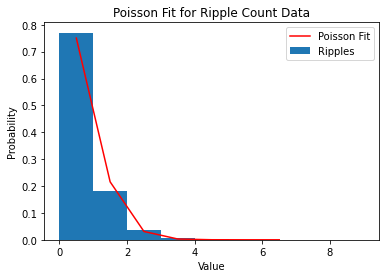

Lambda:  0.2872643283020895
Chi-square test statistic: 456.7098633722155
P-value: 1.538938753870355e-97


In [89]:
import scipy.stats as stats
# Fit the Poisson distribution
test = np.sum(start_array[trial_select & clust_clustered, ripple_swarm_start:ripple_swarm_end], axis=1) / ripple_swarm_duration
test = [int(tt) for tt in test]
lambda_fit = np.mean(test)
print(f'Lambda value: {lambda_fit}')

# Generate values for the Poisson fit
x = np.arange(np.floor(min(test)), np.ceil(max(test)) + 1)
y_fit = stats.poisson.pmf(x, mu=lambda_fit)

# Plot the histogram of the test data with adjusted bin width
plt.hist(test, bins=np.arange(10), density=True, label='Ripples')
plt.plot(x+0.5, y_fit, label='Poisson Fit', color='red')
plt.xlabel('Value')
plt.ylabel('Probability')
plt.title('Poisson Fit for Ripple Count Data')
plt.legend()
plt.show()

# Goodness-of-fit test (e.g., Chi-squared test)
observed = np.bincount(np.array(test))
expected = stats.poisson.pmf(np.arange(len(observed)), mu=lambda_fit) * len(test)
expected = [int(ee) for ee in expected if int(ee) > 0]
expected[0] = expected[0]-1
observed = observed[:len(expected)]
chi2_stat, p_value = stats.chisquare(observed, f_exp=expected)
print("Lambda: ", lambda_fit)
print("Chi-square test statistic:", chi2_stat)
print("P-value:", p_value);

# make plots like in the PNAS 2022 paper

In [20]:
remove_low_freq = 2 # 1 for low gamma/theta; 2 for high gamma/theta

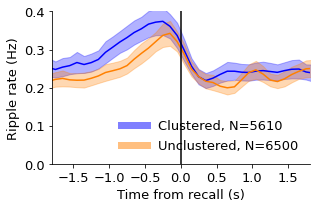

In [23]:
save_plot = 0

# Configuration parameters
bin_size = 100  # in ms
smoothing_triangle = 5  # triangular smoothing window width
font_size = 13  # Settable font size
bar_ylimits = (0, 0.32)

if remove_low_freq == 1:
    trial_select = ~z_low_gamma_trials
elif remove_low_freq == 2:
    trial_select = z_low_gamma_trials
else:
    print('Invalid remove_low_freq selection')
    error    

ripple_swarm_start = int((-ripple_start_offset+ripple_analysis_start)/sr_factor)
ripple_swarm_end = int((-ripple_start_offset+ripple_analysis_end)/sr_factor)
ripple_swarm_duration = (ripple_analysis_end-ripple_analysis_start)/1000  # convert to seconds

# Apply the clust variable to split data into clustered, unclustered, and not recalled
clust_clustered = sub_clust_ID > 1
clust_unclustered = sub_clust_ID < 0
clust_not_recalled = sub_clust_ID == 0

# # Calculate ripple means for each condition
# mean_ripple_clustered = np.sum(start_array[trial_select & clust_clustered, ripple_swarm_start:ripple_swarm_end], axis=1) / ripple_swarm_duration
# mean_ripple_unclustered = np.sum(start_array[trial_select & clust_unclustered, ripple_swarm_start:ripple_swarm_end], axis=1) / ripple_swarm_duration

# Calculate PSTH for each group
ripple_PSTH_clustered, bin_centers = fullPSTH(start_array[trial_select & clust_clustered], bin_size, smoothing_triangle, fs, ripple_start_offset)
ripple_PSTH_unclustered, _ = fullPSTH(start_array[trial_select & clust_unclustered], bin_size, smoothing_triangle, fs, ripple_start_offset)
ripple_PSTH_not_recalled, _ = fullPSTH(start_array[trial_select & clust_not_recalled], bin_size, smoothing_triangle, fs, ripple_start_offset)

# Bin the start_array to match the PSTH and calculate the mean and SE for each bin
n_bins = len(bin_centers)
binned_start_array_clustered = np.array_split(start_array[trial_select & clust_clustered], n_bins, axis=1)
se_clustered = [np.std(bin_data*fs, axis=1) / np.sqrt(bin_data.shape[0]) for bin_data in binned_start_array_clustered]
se_clustered = np.mean(se_clustered, axis=1)

binned_start_array_unclustered = np.array_split(start_array[trial_select & clust_unclustered], n_bins, axis=1)
se_unclustered = [np.std(bin_data*fs, axis=1) / np.sqrt(bin_data.shape[0]) for bin_data in binned_start_array_unclustered]
se_unclustered = np.mean(se_unclustered, axis=1)

if encoding_mode == 1:
    binned_start_array_not_recalled = np.array_split(start_array[trial_select & clust_not_recalled], n_bins, axis=1)
    se_not_recalled = [np.std(bin_data*fs, axis=1) / np.sqrt(bin_data.shape[0]) for bin_data in binned_start_array_not_recalled]
    se_not_recalled = np.mean(se_not_recalled, axis=1)

# Set up the figure with GridSpec
fig = plt.figure(figsize=(4.5, 3))
gs = gridspec.GridSpec(1, 1)
ax_psth = fig.add_subplot(gs[0, 0])

# Define the custom colors
if region_name[0] == 'HPC':
    high_clustered_color = (0.0, 0.0, 1.0) # blue
elif region_name[0] == 'ENT':
    high_clustered_color = (0.7, 0.5, 1.0) # Light purple
low_clustering_color = (1.0, 0.5, 0) # orange
nr_clustering_color = (0, 0.5, 0) # green

# Plot the PSTH for each group
ax_psth.plot(bin_centers / 1000, ripple_PSTH_clustered, label=f'Clustered, N={sum(trial_select&clust_clustered)}', color=high_clustered_color)
ax_psth.plot(bin_centers / 1000, ripple_PSTH_unclustered, label=f'Unclustered, N={sum(trial_select&clust_unclustered)}', color=low_clustering_color)

# Add constant error bands using fill_between
ax_psth.fill_between(bin_centers / 1000, ripple_PSTH_clustered - se_clustered, ripple_PSTH_clustered + se_clustered,
                     color=high_clustered_color, alpha=0.3, label='_nolegend_')
ax_psth.fill_between(bin_centers / 1000, ripple_PSTH_unclustered - se_unclustered, ripple_PSTH_unclustered + se_unclustered,
                     color=low_clustering_color, alpha=0.3, label='_nolegend_')

if encoding_mode == 1:
    ax_psth.plot(bin_centers / 1000, ripple_PSTH_not_recalled, label=f'Not recalled, N={sum(trial_select&clust_not_recalled)}', color=nr_clustering_color)    
    ax_psth.fill_between(bin_centers / 1000, ripple_PSTH_not_recalled - se_not_recalled, ripple_PSTH_not_recalled + se_not_recalled,
                     color=nr_clustering_color, alpha=0.3, label='_nolegend_')

# Add labels and formatting
ax_psth.axvline(x=0.0, color='black', linestyle='-')
ax_psth.set_ylabel('Ripple rate (Hz)', fontsize=font_size)
ax_psth.spines['right'].set_visible(False)
ax_psth.spines['top'].set_visible(False)

# Customize ticks
if encoding_mode == 0:
    ax_psth.set_xlim(-1.8, 1.8)
    ax_psth.set_xticks(np.arange(-1.5, 2.0, 0.5))
    ax_psth.set_ylim(0, 0.4)
    ax_psth.set_yticks(np.arange(0, 0.401, 0.1))
    ax_psth.set_xlabel('Time from recall (s)', fontsize=font_size)
elif encoding_mode == 1:
    ax_psth.set_xlim(-0.3, 2.1)
    ax_psth.set_xticks(np.arange(0, 2.1, 0.5))
    ax_psth.set_ylim(0, 0.4)
    ax_psth.set_yticks(np.arange(0, 0.401, 0.1))
    ax_psth.set_xlabel('Time from word presentation (s)', fontsize=font_size)
ax_psth.tick_params(axis='both', labelsize=font_size)
leg = ax_psth.legend(frameon=False, fontsize=font_size, loc='lower right')
for legobj in leg.legendHandles:
    legobj.set_linewidth(7.0)
    legobj.set_alpha(0.5)

# Adjust layout and show plot
plt.tight_layout()

if save_plot == 1:
    plt.savefig(f'/home1/john/SWRrefactored/figures/ripple_psths/{task}_{saveName}{region_name[0]}_{subregion[0]}_allTrials.pdf',transparent=True) 

plt.show();
